# Navigation

---


### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from dqn_agent import Agent
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="VisualBanana_Windows_x86_64/VisualBanana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
states length:  1
States look like:


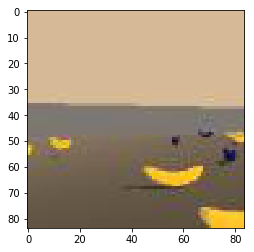

States have shape: (1, 84, 84, 3)
State class:  <class 'numpy.ndarray'>


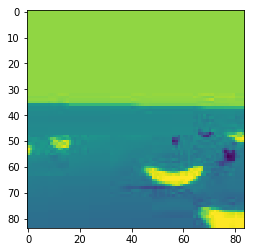

(1, 84, 84, 3)
(1, 84, 84)


In [7]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations
print('states length: ', len(state))
#two_frames = np.concatenate((two_frames, state[0]), axis=0)
#print("two_frames shape: ", two_frames.shape)
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state[0].shape
print('States have shape:', state_size)
print('State class: ', type(state[0]))
state[0].squeeze().shape
plt.imshow(state[0].squeeze()[:,:,0])
plt.show()

image_tensor = state[0]
print(image_tensor.shape)

lum_tensor = extract_luminace(image_tensor)
print(lum_tensor.shape)



In [12]:
n_frames = n_frame_state(extract_luminace(image_tensor), image_tensor)

In [13]:
n_frames.shape

(3, 84, 84)

In [12]:
env.close()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: -1.0


When finished, you can close the environment.

### 4. Train DQConvN
***

In [2]:
def extract_luminace(image_tensor):
    image_tensor = image_tensor.squeeze()
    
    #return np.moveaxis(image_tensor, -1, 0)
    r_lum = np.multiply(image_tensor[:,:,0], 0.2126)
    g_lum = np.multiply(image_tensor[:,:,1], 0.7152)
    b_lum = np.multiply(image_tensor[:,:,2], 0.0722)
    
    lum = r_lum + g_lum + b_lum
    
    return np.expand_dims(lum, axis=0)

In [3]:
def n_frame_state(lum_tensor, new_frame, n_frames=4):
    last_frame = np.expand_dims(lum_tensor[(lum_tensor.shape[0]-1),:,:], axis=0)
    
    while lum_tensor.shape[0] < n_frames:
        lum_tensor = np.concatenate((lum_tensor, last_frame), axis=0)
        
    return np.concatenate((lum_tensor, extract_luminace(new_frame)), axis=0)[1:,:,:]

In [4]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, min_success=100, model_name=''):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    first_min = True                   # have we hit the min "success" metric yet?
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.visual_observations[0]                      # get first frame
        state = n_frame_state(extract_luminace(state), state)        # initiate first state
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = n_frame_state(state, env_info.visual_observations[0])   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if (np.mean(scores_window)>=min_success and first_min):
            first_min = False
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'DConvQN_min_success.pth')
            
            # save results to .txt
            f = open('results/{}.txt'.format(model_name),'w')
            f.write('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            f.close()
    
    # Save final model
    torch.save(agent.qnetwork_local.state_dict(), 'DConvQN_final.pth')
    # save results to .txt
    f = open('results/{}.txt'.format(model_name),'a')
    f.write('\n' + '\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    f.close()
    return scores

## Start the environment

In [5]:
# initiate Banana Unity environment
env = UnityEnvironment(file_name="VisualBanana_Windows_x86_64/VisualBanana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# enable training and reset environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
#print('States look like:', state)
state_size = len(state[0])
print('States have shape:', state.shape)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of actions: 4
States have shape: (1, 84, 84, 3)


## Set agent hyperparameters and initialize

In [6]:
# Set DQN agent hyperparameters
BUFFER_SIZE = int(3e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-4              # for soft update of target parameters
LR = 5e-5               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
ConvDQN = True
M_FRAMES = 4
N_LAYERS = 3
FC1 = 256
FC2 = 128
FC3 = 64                
DDQN = True
PER = False
DUELING = False
DISTRIBUTIONAL = False

hyperams = (BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
layer_units = (N_LAYERS, FC1, FC2, FC3)
extensions = (DDQN, PER, DUELING, DISTRIBUTIONAL)

# Initialize DQN agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0, ConvDQN=ConvDQN, m_frames=M_FRAMES,
              layer_units=layer_units, hyperams=hyperams, extensions=extensions)

## Set environment interaction hyperparameters and start training

In [7]:
# Set training hyperparameters
model_name = "CDQN-32-64-64-512-rms"
n_episodes=500
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995
min_success=13.0

# Train the agent and return scores from each episode
scores = dqn(n_episodes, max_t, eps_start, eps_end, eps_decay, min_success, model_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('results/{}.png'.format(model_name))



# Close environment
env.close()

Episode 100	Average Score: 0.02
Episode 194	Average Score: -0.13

KeyboardInterrupt: 

## Watch the trained agent

1. After the agent has been trained and the network saved...
2. Restart the kernel  
3. Run the first cell (the module imports)  
4. Then run the cell below

In [ ]:
# Initialize Banana game environment
env = UnityEnvironment(file_name="VisualBanana_Windows_x86_64/VisualBanana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
action_size = brain.vector_action_space_size
state = env_info.visual_observations[0]            # get the current state
state_size = len(state)

# Set DQN agent hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
N_LAYERS = 3
FC1 = 256
FC2 = 128
FC3 = 64                
DDQN = True
PER = False
DUELING = False
DISTRIBUTIONAL = False

hyperams = (BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
layer_units = (N_LAYERS, FC1, FC2, FC3)
extensions = (DDQN, PER, DUELING, DISTRIBUTIONAL)

# Initialize DQN agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0,
              layer_units=layer_units, hyperams=hyperams, extensions=extensions)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('final.pth'))

           
score = 0
eps = 0.01
while True:
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
        break 
        
# Close environment
env.close()

In [8]:
env.close()